# What is ARIMA?
ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q). Here p, d, and q are defined as:
1. p is the number of lagged values that need to be added or subtracted from the values (label column). It captures the autoregressive part of ARIMA. 
2. d represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the integrated part of ARIMA.
3. q is the number of lagged values for the error term added or subtracted from the values (label column). It captures the moving average part of ARIMA.

# Time Series Forecasting with ARIMA
We will first collect Google stock price data using the Yahoo Finance API.

In [4]:
!pip install yfinance pandas
!pip install --upgrade yfinance 

In [5]:
#Now here’s the steps to collect data about the Google’s Stock Price:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
# Select only the columns that exist in the DataFrame
data = data[[("Date", ""), ("Open", "GOOG"), ("High", "GOOG"), ("Low", "GOOG"), ("Close", "GOOG"), ("Volume", "GOOG")]]
data.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close    Volume
245 2025-07-11  177.910004  182.610001  177.541000  181.309998  23975700
246 2025-07-14  182.070007  184.729996  180.710999  182.809998  20990400
247 2025-07-15  183.940002  185.410004  182.389999  183.100006  23911600
248 2025-07-16  184.320007  185.335007  183.080002  183.770004  21152600
249 2025-07-17  183.115005  185.186996  181.500000  184.699997  21640200


C:\Users\ACER\AppData\Local\Temp\ipykernel_24756\1982985750.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('GOOG',


From the above data we only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [6]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2024-07-18  178.363724
1 2024-07-19  178.532913
2 2024-07-22  182.473984
3 2024-07-23  182.722809
4 2024-07-24  173.536896


## Data Visualiazation

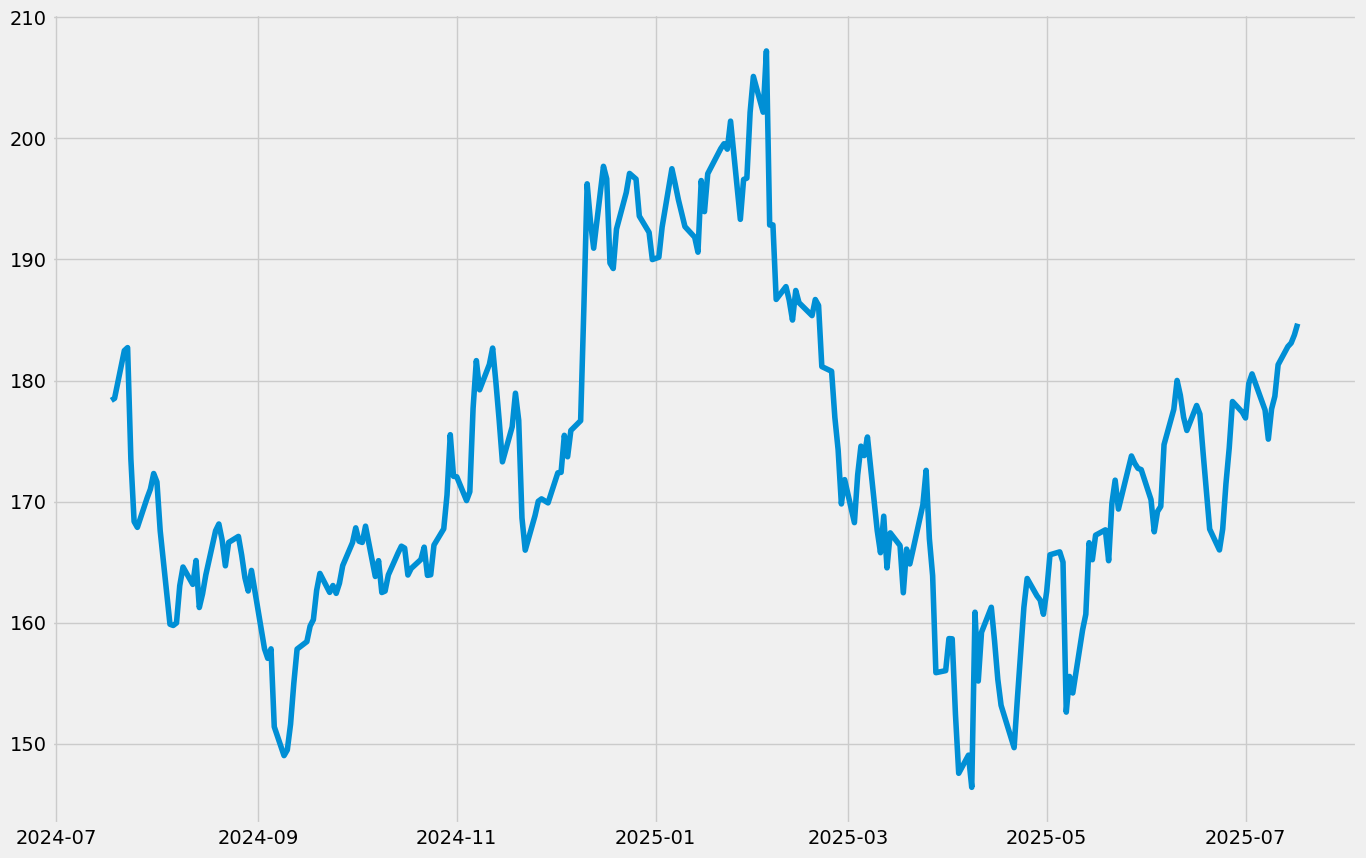

In [7]:
#Now we will visualize the close prices of Google before moving forward:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

# Using ARIMA for Time Series Forecasting
##### We must determine the seasonality of our data before applying the ARIMA model. Our dataset is not stationary, as evidenced by the data visualization graph regarding the closing stock prices shown above. The seasonal decomposition approach, which divides the time series data into trend, seasonal, and residuals for a better understanding of the time series data, can be used to determine whether our dataset is stationary or seasonally appropriate:

<Figure size 640x480 with 0 Axes>

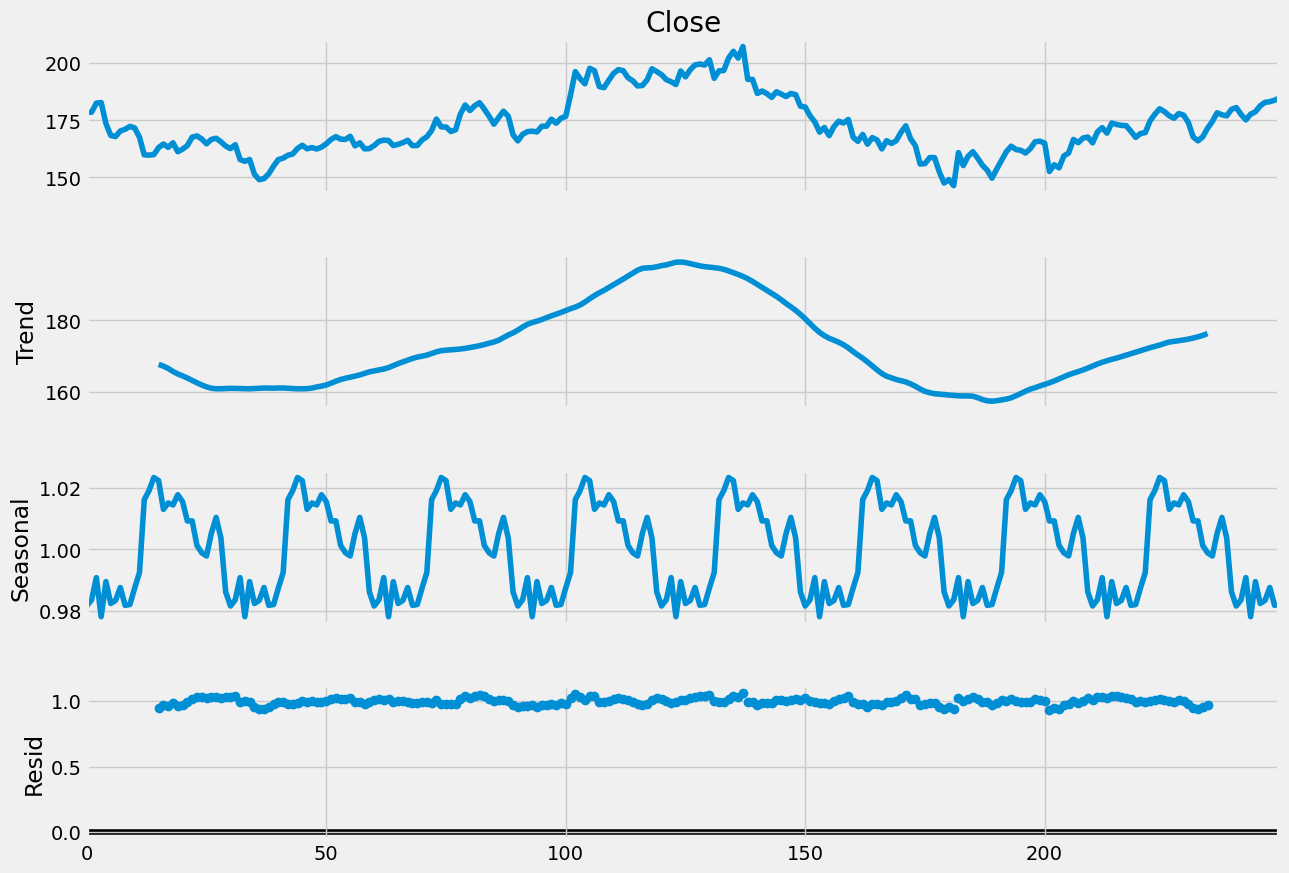

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

##### So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. 
To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

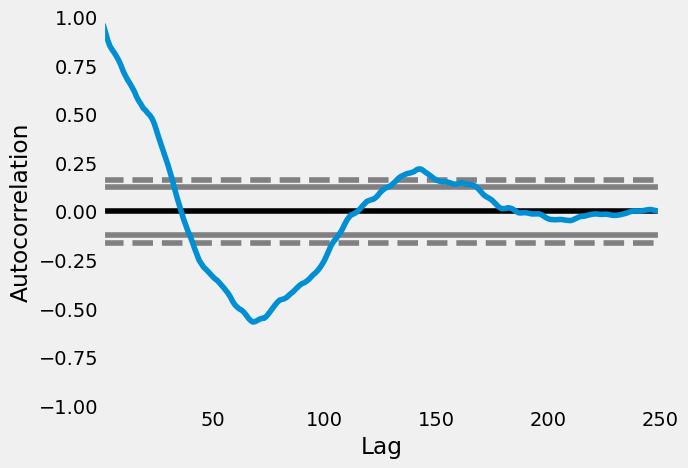

In [10]:
#Now we here’s how we will find the value of p:

pd.plotting.autocorrelation_plot(data["Close"])

##### In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5.

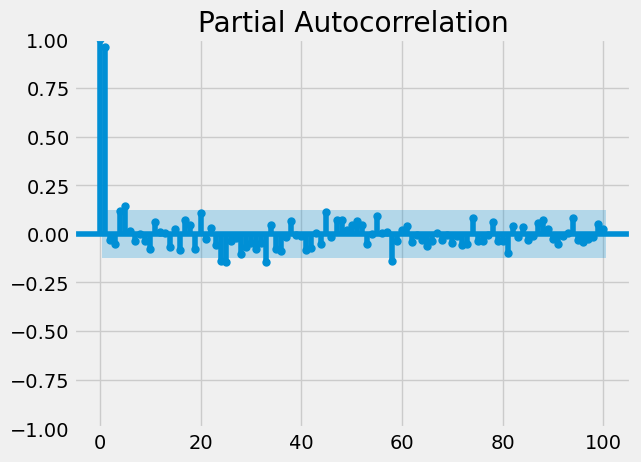

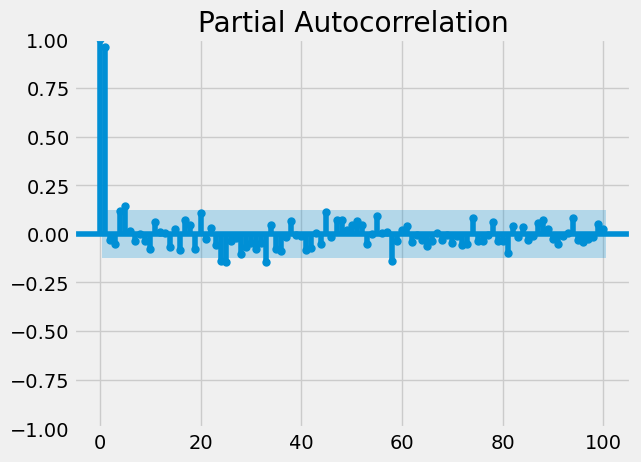

In [11]:
#Now we will find the value of q (moving average):

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

##### In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2.

In [13]:
#Now we will build an ARIMA model:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p, d, q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  250
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -652.641
Date:                Fri, 18 Jul 2025   AIC                           1321.281
Time:                        20:39:31   BIC                           1349.421
Sample:                             0   HQIC                          1332.608
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8716      0.117     -7.443      0.000      -1.101      -0.642
ar.L2         -0.8232      0.112     -7.328      0.000      -1.043      -0.603
ar.L3         -0.0874      0.111     -0.789      0.4

c:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
#Predicting the values using the ARIMA model
predictions = fitted.predict()
print(predictions)

0        0.000000
1      178.363766
2      178.536401
3      182.556189
4      182.837385
          ...    
245    179.650756
246    180.472842
247    182.831917
248    183.120655
249    183.005375
Name: predicted_mean, Length: 250, dtype: float64


##### The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data.

In [15]:
#Building the SARIMA model

import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

c:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  250
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -637.841
Date:                            Fri, 18 Jul 2025   AIC                           1305.682
Time:                                    20:40:54   BIC                           1357.703
Sample:                                         0   HQIC                          1326.650
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3637      1.682     -0.216      0.829      -3.660       2.932
ar.L2         -0.1803      0.336   

In [16]:
#We will now predict the future stock prices using the SARIMA model for the next 10 days
predictions = model.predict(len(data), len(data)+10)
print(predictions)

250    184.513883
251    183.240307
252    183.820921
253    183.445097
254    184.089280
255    183.042146
256    182.210262
257    182.311810
258    183.008751
259    183.664965
260    184.314941
Name: predicted_mean, dtype: float64


<Axes: >

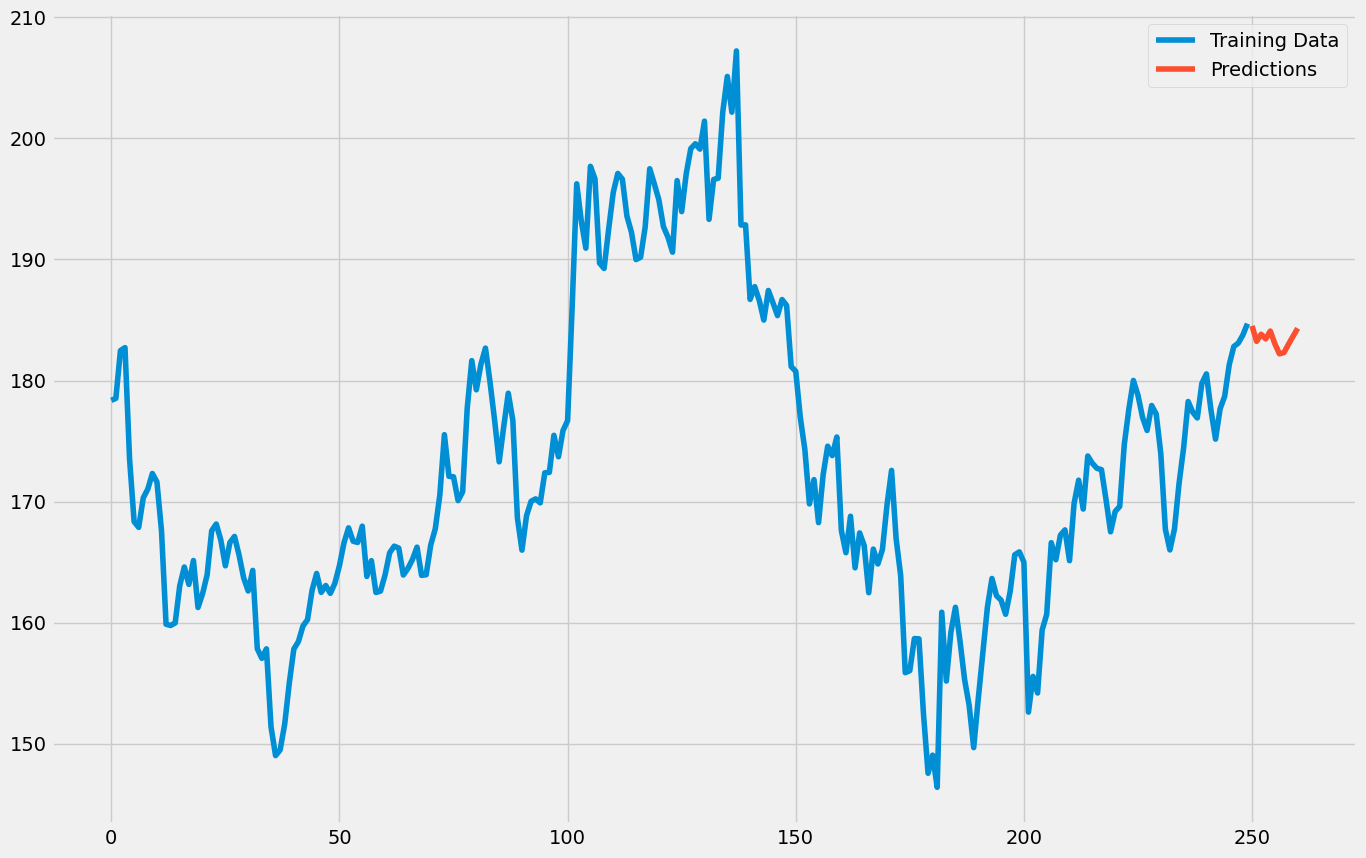

In [17]:
#Plotting the predictions
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

# Summary
#### ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA).